Experimentation with flood fill and analysis of clouds/shadow regions in opencv

In [29]:
import numpy as np
import cv2
import os
import rasterio
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from bokeh.plotting import figure, show
from pathlib import Path
import matplotlib as mpl
from matplotlib import colors

mpl.rcParams['figure.dpi'] = 150


In [2]:
base_path = "/home/ebiederstadt/Documents/sentinel_cache/bbox-111.9314176_56.921209032_-111.6817217_57.105787570"
date = "2019-05-22"

cloud_dataset = rasterio.open(os.path.join(base_path, date, "cloud_mask.tif"))
clouds = cloud_dataset.read(1)
shadow_dataset = rasterio.open(os.path.join(base_path, date, "shadow_mask.tif"))
shadows = shadow_dataset.read(1)

result = np.logical_or(clouds, shadows)
result = result.astype(np.float32)

cmap = ListedColormap(["gold", "lightseagreen"])

plt.imshow(result, cmap=cmap)
plt.title("Invalid Pixels over a region of interest")
plt.colorbar()
plt.tight_layout()
plt.savefig("clouds_and_shadows.png", dpi=300)

NameError: name 'rasterio' is not defined

In [4]:
height, width = result.shape

flood_result = result.copy()
flood_result[flood_result == 1] = -100

pixels = []

nelem = 0
for x in range(height):
    for y in range(width):
        if flood_result[x, y] == -100:
            nelem += 1
            num_filled_pixels, image, _, _ = cv2.floodFill(flood_result, None, (y, x), nelem, flags=8)
            # if num_filled_pixels < 50:
            #     flood_result[flood_result == nelem] = 0
            # else:
            flood_result[flood_result == nelem] = num_filled_pixels
            pixels.append(num_filled_pixels)
                
pixels = np.asarray(pixels)
pixels

array([ 83, 114, 285, ...,   8,  20,   6])

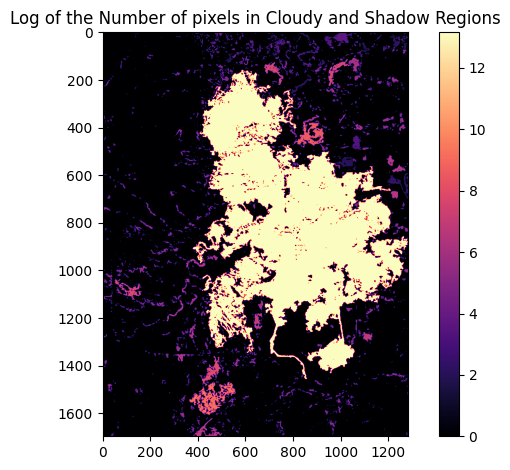

In [6]:
pixels.sort()

log_result = np.log(flood_result, out=np.zeros_like(flood_result), where=(flood_result != 0))
plt.imshow(log_result, cmap="magma",)
plt.title("Log of the Number of pixels in Cloudy and Shadow Regions")
plt.colorbar()
plt.tight_layout()
plt.savefig("flood_result.png", dpi=300)

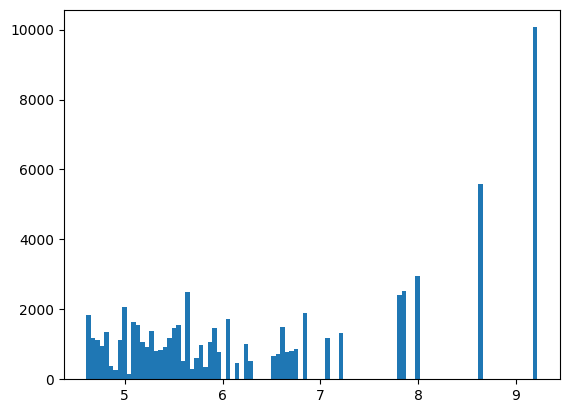

In [30]:
flattened_result = log_result.flatten()
flattened_result = flattened_result[flattened_result > 0] # Remove zero pixels -> They don't mean anything in our analysis
flattened_subset = flattened_result[flattened_result < max(flattened_result)]

plt.hist(flattened_subset, bins=100)
plt.show()

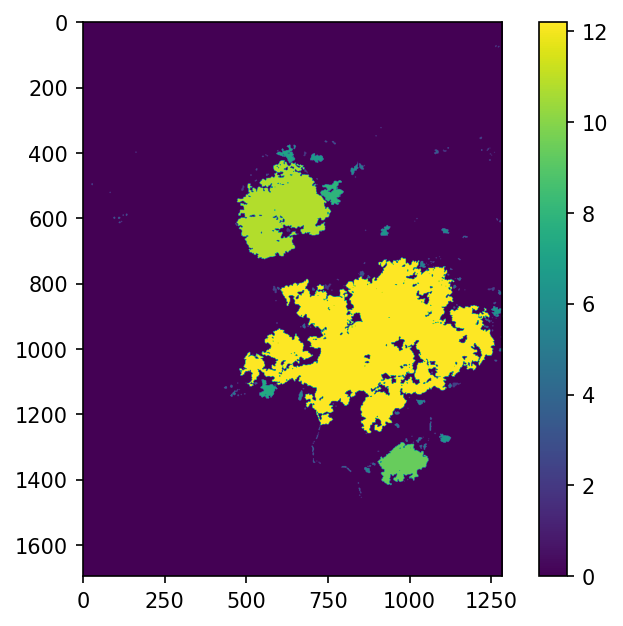

In [20]:
base_path = Path("/home/ebiederstadt/Documents/sentinel_cache/bbox-111.9314176_56.921209032_-111.6817217_57.105787570/2019-05-22/testing_cloud_detection")
simple_mask = rasterio.open(base_path.joinpath("new_mask.tif")).read(1)

height, width = simple_mask.shape

simple_mask = simple_mask.astype(np.float32)
flood_result = simple_mask.copy()
flood_result[flood_result == 1] = -100

nelem = 0
for x in range(height):
    for y in range(width):
        if flood_result[x, y] == -100:
            nelem += 1
            num_filled_pixels, image, _, _ = cv2.floodFill(flood_result, None, (y, x), nelem, flags=8)
            flood_result[flood_result == nelem] = num_filled_pixels

log_result = np.log(flood_result, out=np.zeros_like(flood_result), where=(flood_result != 0))
plt.imshow(log_result)
plt.colorbar()

(-0.5, 1283.5, 1696.5, -0.5)

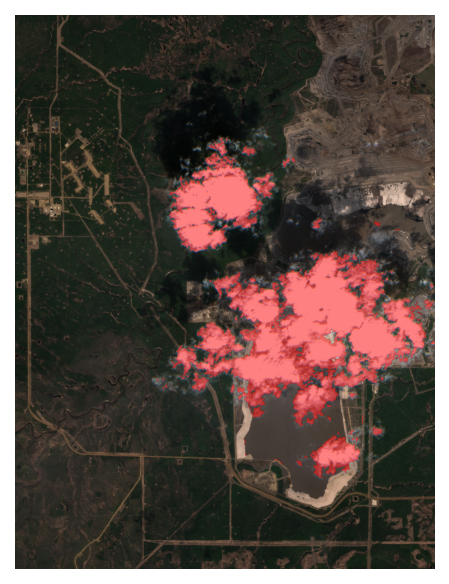

In [33]:
# Discard any area that was smaller than 40 pixels in size
new_binary_mask = (flood_result > 40).astype(int)

rgb = rasterio.open(base_path.parent.joinpath("RGB.tif")).read()
rgb_image = np.transpose(rgb, (1, 2, 0))

norm = colors.Normalize(vmin=rgb_image.min(), vmax=rgb_image.max())
rgb_image = norm(rgb_image)

plt.imshow(rgb_image)
mask_image = np.zeros((*new_binary_mask.shape, 4))
mask_image[..., 0] = new_binary_mask
mask_image[..., 3] = new_binary_mask * 0.5
plt.imshow(mask_image)
plt.axis("off")